## XGBoost Model

In [43]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import shap
import xgboost as xgb

import seaborn as sns

In [44]:
hockey = pd.read_csv('hockey1.csv')

In [45]:
hockey.drop(['Progress','LocationLatitude','LocationLongitude','Q2',
             'Q2_7_TEXT', 'Q9', 'Q22_6_TEXT', 'Q25_7_TEXT', 'Q39', 'Q41', 'Q43',
             'Q13', 'Q28','X'], axis= 1, inplace= True)
hockey.dropna(subset= ['Q40'], inplace= True)
hockey['Q40'].replace('64&89', '64', inplace=True)
hockey['Q40'] = hockey['Q40'].astype('int')

hockey['Q33'] = hockey['Q33'].apply(lambda x: 0 if x == 'No' else 1)

In [46]:
# Q31 list:
Q13_ls = []
for i in range(1,13):
    Q13_ls.append('Q31_' + str(i))
#Fill na
hockey[Q13_ls].fillna(2, inplace= True)
hockey['Q32'].fillna(2, inplace= True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [47]:
X_train = hockey.drop('Q42', axis= 1)
y_train = hockey['Q42']

In [48]:
y_train = y_train.replace({0:1, 1:0})
y_train

0      0
1      0
2      0
3      0
4      1
      ..
408    1
409    0
410    0
411    0
412    0
Name: Q42, Length: 404, dtype: int64

In [49]:
vdt = X_train.dtypes.to_frame(name = 'dtype')
obj_var = list(vdt[vdt['dtype'] == 'object'].index)

In [50]:
X_train = pd.get_dummies(X_train, columns = obj_var)
X_train.head()

,Q3,Q4,Q6,Q14,Q15,Q16,Q17,Q20_1,Q20_2,Q20_3,...,"Q25_Videoboard content,Merchandise","Q25_Videoboard content,Parking","Q25_Videoboard content,Parking,Merchandise","Q25_Videoboard content,Parking,Other (please specify)",Q32_2,Q32_Likely,Q32_Neither unlikely nor likely,Q32_Unlikely,Q32_Very likely,Q32_Very unlikely
0,7.0,9.0,1.0,5.0,5.0,5.0,0.0,5.0,5.0,5.0,...,0,0,0,0,0,1,0,0,0,0
1,1.0,4.0,1.0,NaN,NaN,NaN,0.0,5.0,4.0,5.0,...,0,0,0,0,0,1,0,0,0,0
2,20.0,10.0,1.0,NaN,NaN,NaN,1.0,5.0,5.0,5.0,...,0,0,0,0,0,1,0,0,0,0
3,5.0,4.0,1.0,NaN,5.0,NaN,0.0,5.0,5.0,5.0,...,0,0,0,0,0,0,1,0,0,0
4,5.0,12.0,0.0,2.0,2.0,NaN,0.0,5.0,5.0,5.0,...,0,0,0,0,0,0,1,0,0,0


In [51]:
spw = len(y_train[y_train == 0])/len(y_train[y_train == 1])
spw

20.263157894736842

In [52]:
xgb_simple = xgb.XGBClassifier(objective = 'binary:logistic',  
                               seed = 777,
                               scale_pos_weight = spw) 

In [53]:
xgb_simple.set_params(early_stopping_rounds = 10, #set early stopping rounds to increase the effiency of modeling
                      eval_metric = 'aucpr') # set evaluation metric which is the method checking the performance of learning

xgb_simple.fit(X_train,
               y_train,
               verbose = 10,
               eval_set = [(X_train, y_train)])

[0]	validation_0-aucpr:0.47113
[10]	validation_0-aucpr:1.00000
[12]	validation_0-aucpr:1.00000


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

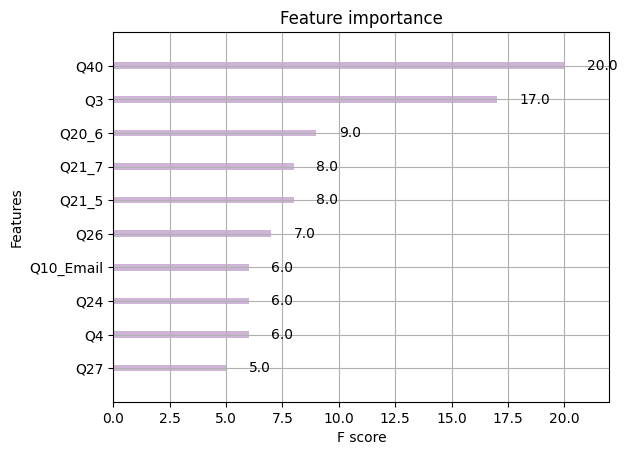

In [54]:
xgb.plot_importance(xgb_simple, max_num_features = 10)

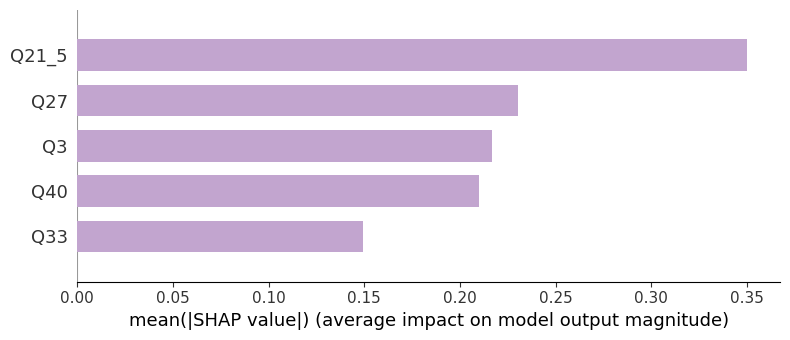

In [71]:
# Calculate SHAP values for the training data
explainer = shap.Explainer(xgb_simple)
shap_values = explainer(X_train)

# Plot the SHAP summary plot for the top 10 features
shap.summary_plot(shap_values, X_train, plot_type='bar', max_display= 5, color= '#c2a5cf')

In [56]:
sns.set_palette('PRGn', n_colors = 2)

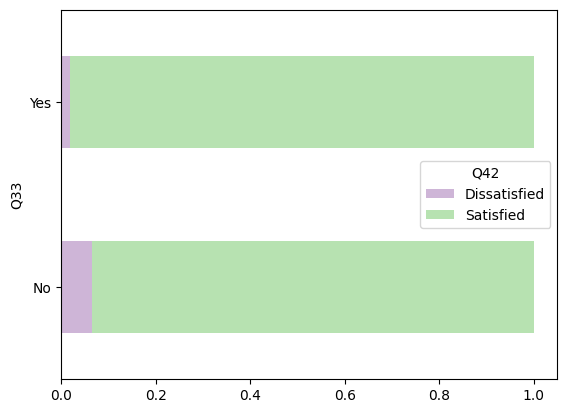

In [57]:
hp = hockey.groupby('Q33')['Q42'].value_counts(normalize= True).unstack().plot(kind = 'barh',
                                                                     stacked = True)
legend_labels = hp.get_legend_handles_labels()[1]

# Create new legend labels
new_labels = ["Dissatisfied", "Satisfied"]

hp.set_yticklabels(['No','Yes'])

# Replace old legend labels with new ones
for t, l in zip(hp.legend_.texts, new_labels):
    t.set_text(l)

# Show plot
plt.show()

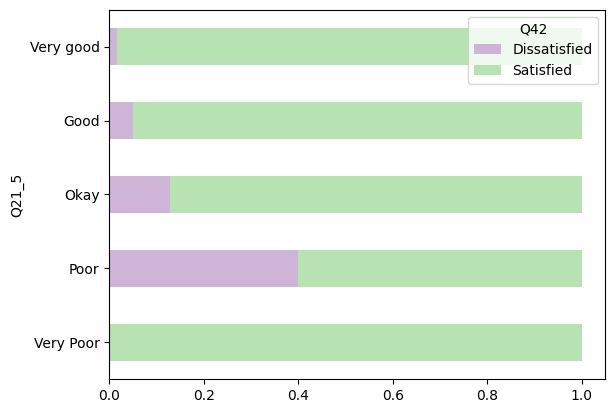

In [58]:
hp = hockey.groupby('Q21_5')['Q42'].value_counts(normalize= True).unstack().plot(kind = 'barh',
                                                                     stacked = True)

legend_labels = hp.get_legend_handles_labels()[1]

hp.set_yticklabels(['Very Poor','Poor','Okay', 'Good', 'Very good'])

# Create new legend labels
new_labels = ["Dissatisfied", "Satisfied"]

# Replace old legend labels with new ones
for t, l in zip(hp.legend_.texts, new_labels):
    t.set_text(l)

# Show plot
plt.show()

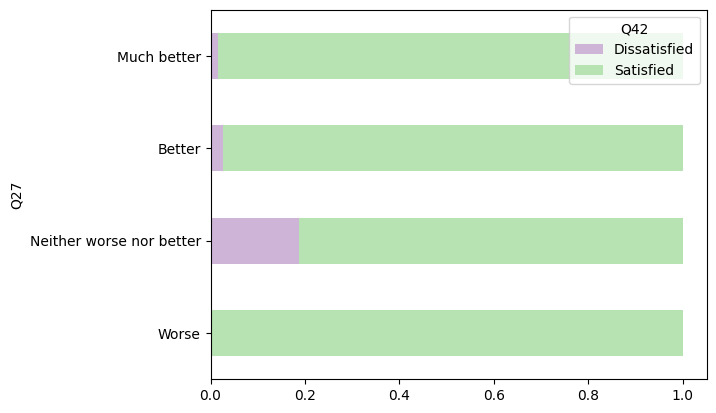

In [59]:
hp = hockey.groupby('Q27')['Q42'].value_counts(normalize= True).unstack().plot(kind = 'barh',
                                                                     stacked = True)
legend_labels = hp.get_legend_handles_labels()[1]

hp.set_yticklabels(['Worse','Neither worse nor better', 'Better', 'Much better'])

# Create new legend labels
new_labels = ["Dissatisfied", "Satisfied"]

# Replace old legend labels with new ones
for t, l in zip(hp.legend_.texts, new_labels):
    t.set_text(l)

# Show plot
plt.show()

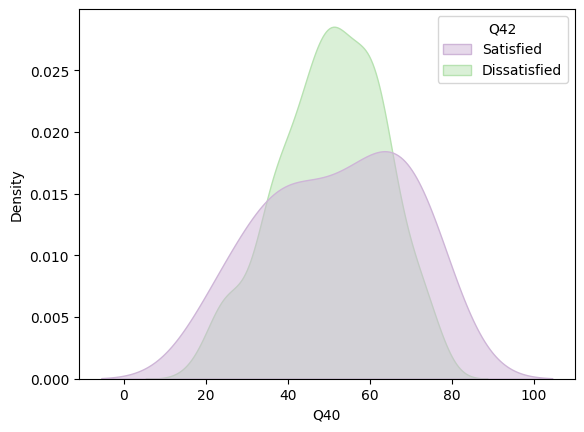

In [60]:
hp = sns.kdeplot(x = 'Q40',
                data = hockey,
                hue = 'Q42',
                alpha = .5,
                fill = True,
                common_norm = False)


# Get current legend labels
legend_labels = hp.get_legend_handles_labels()[1]

# Create new legend labels
new_labels = ["Satisfied", "Dissatisfied"]

# Replace old legend labels with new ones
for t, l in zip(hp.legend_.texts, new_labels):
    t.set_text(l)

# Show plot
plt.show()

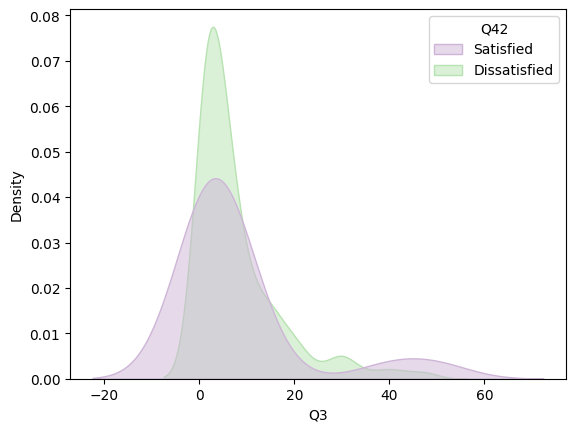

In [61]:
hp = sns.kdeplot(x = 'Q3',
             data = hockey,
             hue = 'Q42',
             alpha = .5,
             fill = True,
             common_norm = False)


# Get current legend labels
legend_labels = hp.get_legend_handles_labels()[1]

# Create new legend labels
new_labels = ["Satisfied", "Dissatisfied"]

# Replace old legend labels with new ones
for t, l in zip(hp.legend_.texts, new_labels):
    t.set_text(l)

# Show plot
plt.show()

<Axes: >

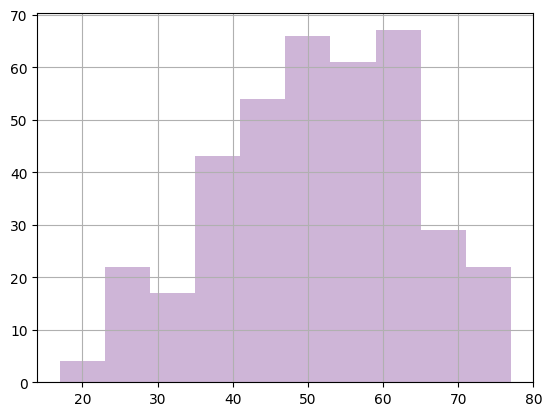

In [74]:
hockey[hockey['Q42'] == 1]['Q40'].hist()